# Model evaluation & cross-validation

[José C. García Alanis (he/him)](https://github.com/JoseAlanis)  
Research Fellow - Child and Adolescent Psychology at [Uni Marburg](https://www.uni-marburg.de/de)  
Member - [RTG 2271 | Breaking Expectations](https://www.uni-marburg.de/en/fb04/rtg-2271), [Brainhack](https://brainhack.org/)

<img align="left" src="https://raw.githubusercontent.com/G0RELLA/gorella_mwn/master/lecture/static/Twitter%20social%20icons%20-%20circle%20-%20blue.png" alt="logo" title="Twitter" width="30" height="30" /> <img align="left" src="https://raw.githubusercontent.com/G0RELLA/gorella_mwn/master/lecture/static/GitHub-Mark-120px-plus.png" alt="logo" title="Github" width="30" height="30" />   &nbsp;&nbsp;@JoiAlhaniz 


<img align="right" src="https://raw.githubusercontent.com/PeerHerholz/ML-DL_workshop_SynAGE/master/lecture/static/ml-dl_workshop.png" alt="logo" title="Github" width="400" height="280" />


### Aim(s) of this section

As mention in the previous section, it is not sufficient to apply these methods to learn somthing about the nature of our data. It is always necessary to assess the quality of the implemented model. The goal of these section is to look at ways to estimate the generalization accuracy of a model on future (e.g.,unseen, out-of-sample) data.

In other words, at the end of these sections you should know:
- 1) different techniques to evaluate a given model
- 2) understand the basic idea of cross-validation and different kinds of the same
- 3) get an idea how to assess the significance (e.g., via permutation tests)

### Prepare data for model

Lets bring back our example data set (you know the song ...)

In [4]:
import numpy as np
import pandas as pd

# get the data set
data = np.load('MAIN2019_BASC064_subsamp_features.npz')['a']

# get the labels
info = pd.read_csv('participants.csv')


print('There are %s samples and %s features' % (data.shape[0], data.shape[1]))

There are 155 samples and 2016 features


Now let's look at the labels

In [5]:
info.head(n=5)

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


We'll set `Age` as target
- i.e., well look at these from the `regression` perspective

In [6]:
# set age as target
Y_con = info['Age']
Y_con.describe()

count    155.000000
mean      10.555189
std        8.071957
min        3.518138
25%        5.300000
50%        7.680000
75%       10.975000
max       39.000000
Name: Age, dtype: float64

Next:
- we need to divide our input data `X` into `training` and `test` sets

In [7]:
# import necessary python modules
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data
X_train, X_test, y_train, y_test = train_test_split(data, Y_con, random_state=0)

Now lets look at the size of the data sets

In [8]:
# print the size of our training and test groups
print('N used for training:', len(X_train),
      ' |  N used for testing:', len(X_test))

N used for training: 116  |  N used for testing: 39


**Question:** Is that a good distribution? Does it look ok?

- Why might this be problematic (hint: what do you know about groups (e.g., `Child_Adult`) in the data.

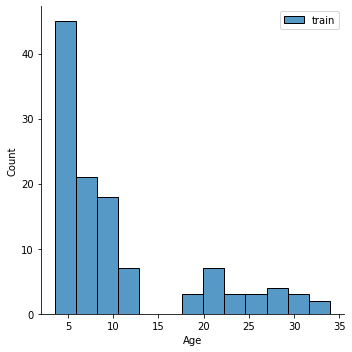

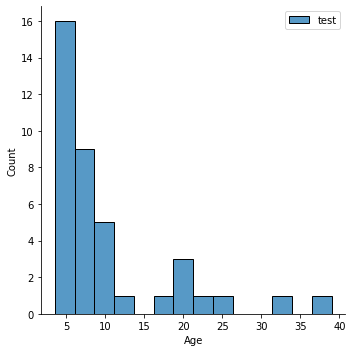

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(y_train,label='train')
plt.legend()
sns.displot(y_test,label='test')
plt.legend()

### Model fit

Now lets go ahead and fit the model
- we will use a fairly standard regression model called a Support Vector Regressor (SVR)
  - similar to the one we used in the previous section

In [10]:
from sklearn.svm import SVR

# define the model
lin_svr = SVR(kernel='linear')

# fit the model
lin_svr.fit(X_train, y_train)

SVR(kernel='linear')

### Model diagnostics

Now let's look at how the model performs in predicting the data
- we can use the `score` method to calculate the coefficient of determination (or [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination)) of the prediction.
  - for this we compare the observed data to the predicted data

In [11]:
# predict the training data based on the model
y_pred = lin_svr.predict(X_train) 

# caluclate the model accuracy
acc = lin_svr.score(X_train, y_train)

In [12]:
# print results
print('accuracy (R2)', acc)

accuracy (R2) 0.9998468951478122


Now lets plot the predicted values

Text(0.5, 0, 'Predicted Age')

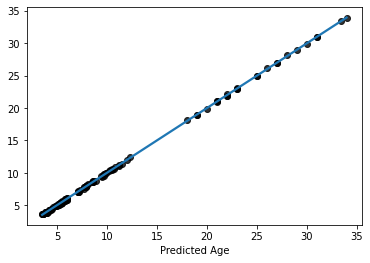

In [13]:
sns.regplot(y=y_pred, x=y_train, scatter_kws=dict(color='k'))
plt.xlabel('Predicted Age')

Now thats really cool, eh? **Almost a perfect fit**

... which means something is wrong
- what are we missing here?

- **recall**: We are still using the test data sets.

<center><img src="https://raw.githubusercontent.com/neurodatascience/course-materials-2020/master/lectures/14-may/03-intro-to-machine-learning/Imgs/regr.jpg" alt="logo" title="Github" width="800" height="500" /><center>

<br>

### Train/test stratification

Now lets do this again but we'll add some constraints to the predriction
- Well keey the 75/25 ratio between test and train data sets
- But now we will try to keep the characteristics of the data set consistent accross training and test datasets
- For this we will use something called [stratification](https://en.wikipedia.org/wiki/Stratified_sampling)

In [14]:
# use `AgeGroup` for stratification
age_class2 = info.loc[y_train.index,'AgeGroup']

# split the data
X_train2, X_test, y_train2, y_test = train_test_split(
    X_train, # x
    y_train, # y
    test_size = 0.25, # 75%/25% split  
    shuffle = True, # shuffle dataset before splitting
    stratify = age_class2,  # keep distribution of age class consistent
                            # betw. train & test sets.
    random_state = 0 # same shuffle each time
)

Let's re-fit the model on the newly computed (and stratified) train data and evaluate it' performace on an (also stratified) test data
- We'll compute again the model accuracy (R-squared) to evalueate the models performance,
- but we'll also have a look at the [mean-absolute-error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE), it is measured as the average sum of the absolute diffrences between predictions and actual observations. Unlike other measures, MAE is more robust to outliers, since it doesn't square the deviations (cf. [mean-squared-error](https://en.wikipedia.org/wiki/Mean_squared_error))
  - it provides a way to asses "how far off" are our predictions from our actual data, while staying on it's referential space

In [15]:
from sklearn.metrics import mean_absolute_error

# fit model just to training data
lin_svr.fit(X_train2, y_train2)

# predict the *test* data based on the model trained on X_train2
y_pred = lin_svr.predict(X_test) 

# calculate the model accuracy
acc = lin_svr.score(X_test, y_test) 
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)

Lets check the results

In [16]:
# print results
print('accuracy (R2) = ', acc)
print('MAE = ', mae)

accuracy (R2) =  0.6593855081680796
MAE =  3.2059201603105882


Text(0.5, 0, 'Predicted Age')

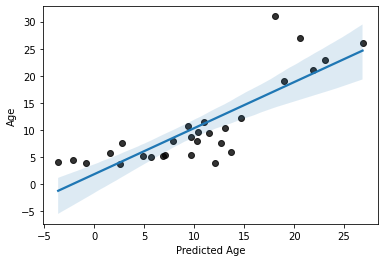

In [19]:
# plot results
sns.regplot(x=y_pred,y=y_test, scatter_kws=dict(color='k'))
plt.xlabel('Predicted Age')

### [Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

Not perfect, but its not bad, as far as predicting with unseen data goes. Especially with a training sample of "only" 69 subjects.

- But, can we do better?
- On thing we could do is increase the size our training set while simultaneously reducing bias by instead using 10-fold **cross-validation**

<center><img src="https://raw.githubusercontent.com/neurodatascience/course-materials-2020/master/lectures/14-may/03-intro-to-machine-learning/Imgs/KCV2.png" alt="logo" title="Github" width="600" height="500" /></center>
    
<br>

Cross-validation is a technique used to protect against biases in a predictive model
- particularly useful in cases where the amount of data may be limited. 
- basic idea: you partition the data in a fixed number of folds, run the analysis on each fold, and then average out the overall error estimate

Let's look at the models performance across 10 folds

In [20]:
# import modules needed for cross-validation
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(lin_svr, X_train, y_train, cv=10)
# scores
acc = cross_val_score(lin_svr, X_train, y_train, cv=10)
mae = cross_val_score(lin_svr, X_train, y_train, cv=10, 
                      scoring='neg_mean_absolute_error')
# negative MAE is simply the negative of the 
# MAE (by definition a positive quantity),  
# since MAE is an error metric, i.e. the lower the better, 
# negative MAE is the opposite

In [39]:
# print the results for each fold
for i in range(10):
    print(
        'Fold {} -- Acc = {}, MAE = {}'.format(i, np.round(acc[i], 3), np.round(-mae[i], 3))
    )

Fold 0 -- Acc = 0.419, MAE = 5.271
Fold 1 -- Acc = 0.11, MAE = 3.069
Fold 2 -- Acc = 0.79, MAE = 2.275
Fold 3 -- Acc = 0.809, MAE = 3.061
Fold 4 -- Acc = 0.641, MAE = 3.906
Fold 5 -- Acc = 0.195, MAE = 4.732
Fold 6 -- Acc = 0.684, MAE = 3.974
Fold 7 -- Acc = 0.815, MAE = 2.693
Fold 8 -- Acc = 0.058, MAE = 5.525
Fold 9 -- Acc = 0.698, MAE = 2.571


For the visually oriented among us

Text(0, 0.5, 'Metric score [i.e., R-squared 0 to 1]')

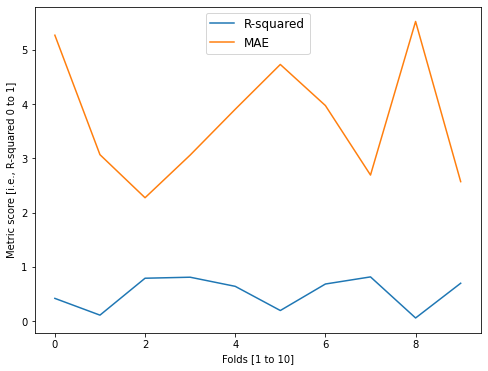

In [84]:
fig = plt.figure(figsize=(8, 6))
plt.plot(acc, label = 'R-squared')
plt.legend()
plt.plot(-mae, label = 'MAE')
plt.legend(prop={'size': 12}, loc=9)
plt.xlabel('Folds [1 to 10]')
plt.ylabel('Metric score [i.e., R-squared 0 to 1]')

We can also look at the **overall accuracy** of the model

In [85]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)

print('R2:', overall_acc)
print('MAE:', overall_mae)

R2: 0.5544107024745264
MAE: 3.7082530497804926


Now, let's look at the final overall model prediction

Text(0, 0.5, 'Predicted Age')

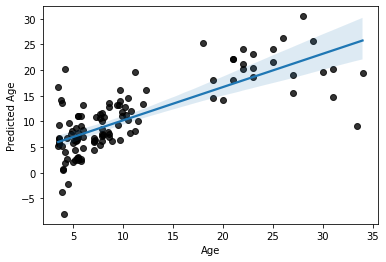

In [86]:
sns.regplot(x=y_train, y=y_pred, scatter_kws=dict(color='k'))
plt.ylabel('Predicted Age')

### Summary

Not bad, not bad at all.

But **most importantly**
- this is a more **accurate estimation** of our model's predictive efficacy.